In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import cv2
import os
import time
from preprocessing import PreProcessing
from model import TripletLoss

c:\users\kuruparans\anaconda3\envs\imtf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kuruparans\anaconda3\envs\imtf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kuruparans\anaconda3\envs\imtf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\kuruparans\anaconda3\envs\imtf\lib\site-packages\ten

In [2]:
# Read Dataset. Split into training and test set
def get_train_test_dataset(train_test_ratio):
    data_src = './data_repository/Veri776/'
    X = []
    y = []
    for directory in os.listdir(data_src):
        try:
            for pic in os.listdir(os.path.join(data_src, directory)):
                img = cv2.imread(os.path.join(data_src, directory, pic))
                img = cv2.resize(img, (28, 28)) 

                X.append(np.squeeze(np.asarray(img)))
                y.append(directory)
        except:
            pass

    labels = list(set(y))
    label_dict = dict(zip(labels, range(len(labels))))
    Y = np.asarray([label_dict[label] for label in y])
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = []
    y_shuffled = []
    for index in shuffle_indices:
        x_shuffled.append(X[index])
        y_shuffled.append(Y[index])

    size_of_dataset = len(x_shuffled)
    n_train = int(np.ceil(size_of_dataset * train_test_ratio))
    n_test = int(np.ceil(size_of_dataset * (1 - train_test_ratio)))
    return np.asarray(x_shuffled[0:n_train]), np.asarray(x_shuffled[n_train + 1:size_of_dataset]), np.asarray(y_shuffled[0:n_train]), np.asarray(y_shuffled[
                                                                                                  n_train + 1:size_of_dataset])

In [3]:
train_images, test_images, train_label, test_label = get_train_test_dataset(0.7)

In [4]:
test_images.shape

(14795, 28, 28, 3)

In [5]:
train_images.shape


(34527, 28, 28, 3)

In [6]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,:])
        ax.axis('off')
    plt.show()

## Triplet Loss

In [7]:
#model_path = './trained_model/model_triplet/'

In [8]:
model_path = './model_triplet/'

In [9]:
model = TripletLoss()

In [10]:
# Input and Output Tensor
img_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 3], name='img')
net = model.conv_net(img_placeholder, reuse=False)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.


********** QUERY IMAGE **********


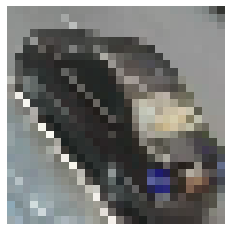

In [11]:
# Generate random index from test_images corpus and display the image
idx = np.random.randint(0, len(test_images))
im = test_images[idx]

#show the test image
print("********** QUERY IMAGE **********")
show_image(idx, test_images)

In [12]:
len(test_images)

14795

In [13]:
test_images[0]

array([[[ 23,  29,  28],
        [ 24,  29,  28],
        [ 25,  25,  25],
        ...,
        [167, 173, 178],
        [170, 177, 186],
        [165, 169, 180]],

       [[ 25,  30,  29],
        [ 25,  30,  29],
        [ 26,  26,  26],
        ...,
        [162, 166, 171],
        [165, 167, 178],
        [169, 171, 182]],

       [[ 31,  31,  31],
        [ 26,  31,  30],
        [ 28,  31,  29],
        ...,
        [174, 172, 174],
        [202, 202, 208],
        [156, 155, 164]],

       ...,

       [[ 30,  37,  34],
        [ 44,  45,  43],
        [ 38,  39,  37],
        ...,
        [130, 127, 118],
        [137, 134, 126],
        [140, 131, 127]],

       [[ 32,  38,  33],
        [ 52,  53,  53],
        [ 49,  49,  49],
        ...,
        [113, 110, 102],
        [138, 132, 125],
        [139, 130, 126]],

       [[ 31,  38,  35],
        [ 55,  58,  58],
        [ 60,  60,  60],
        ...,
        [109, 106, 101],
        [129, 124, 118],
        [135, 129, 124]]

In [14]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)
def parse_img(img, label):
    return (img, label)
test_dataset = _normalize_img(test_images,test_label)
train_dataset = _normalize_img(train_images,train_label)



## Find k nearest neighbour using cosine similarity 

In [15]:
# Compute Vector representation for each training images and normalize those
def generate_db_normed_vectors():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, model_path+"model.ckpt")
        train_vectors = sess.run(net, feed_dict={img_placeholder:train_images})      
    normalized_train_vectors = train_vectors/np.linalg.norm(train_vectors,axis=1).reshape(-1,1)
    return normalized_train_vectors

In [16]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(normalized_train_vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

In [17]:
normalized_training_vectors = generate_db_normed_vectors()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [18]:
# Compute vector representation of test image 
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vector = sess.run(net, feed_dict={img_placeholder:[im]}) 
normalized_search_vec = search_vector/np.linalg.norm(search_vector)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [19]:
normalized_search_vec

array([[ 0.15401907, -0.06424882, -0.3465035 , -0.01413571,  0.1636547 ,
        -0.3205883 ,  0.19733697,  0.24724293,  0.05137726,  0.19515876,
        -0.06147821, -0.01539677, -0.2853288 , -0.12608601,  0.0855033 ,
        -0.19929737,  0.09459601, -0.09292828,  0.08468954,  0.16190174,
        -0.12066044, -0.1404993 , -0.21379365, -0.17265016, -0.13626377,
         0.37665892, -0.2880786 ,  0.17017327]], dtype=float32)

Total time to find nn: 3.00 ms


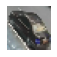

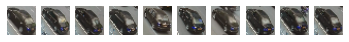

Index of Similar images: [18425 15885  7092 20344 29134 10800  7366 18940 27048 15944]


In [20]:
s_time = time.time()
k = 10
candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vec, k)
print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))
fig = plt.figure(figsize=(10, 0.8))
idxs = [idx]
gs = gridspec.GridSpec(1, len(idxs))
# plot test image
for i in range(len(idxs)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
# plot similar images
show_image(candidate_index, train_images)
print("Index of Similar images:", candidate_index)

Total time to find nn: 2.00 ms


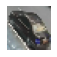

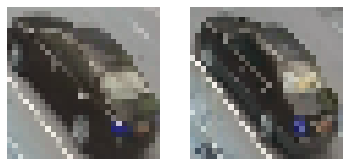

Index of Similar images: [18425 15885]


In [21]:
s_time = time.time()
k = 2
candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vec, k)
print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))
fig = plt.figure(figsize=(10, 0.8))
idxs = [idx]
gs = gridspec.GridSpec(1, len(idxs))
# plot test image
for i in range(len(idxs)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
# plot similar images
show_image(candidate_index, train_images)
print("Index of Similar images:", candidate_index)

## VISUALIZATION 

In [22]:
#helper function to plot imageS
def show_top_k_images(indx_list,test_image_indexes, train_data, test_data):
    fig = plt.figure(figsize=(20, 40))
    gs = gridspec.GridSpec(len(indx_list),len(indx_list[0])+2)
    for i in range(len(indx_list)):
        ax = fig.add_subplot(gs[i,0])
        ax.imshow(test_data[test_image_indexes[i],:,:,:])
        ax.axis('off')
        for j in range(len(indx_list[0])):
            ax = fig.add_subplot(gs[i,j+2])
            ax.imshow(train_data[indx_list[i][j],:,:,:])
            ax.axis('off')
    plt.savefig('./figures/similar_images.jpg')
    plt.show()

In [23]:
K = 20
N = 20
indx_list = []
test_image_indexes = []
_test_images = []
for i in range(N):
    idx = i
    test_image_indexes.append(idx)
    _test_images.append(test_images[idx])
    #run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vectors = sess.run(net, feed_dict={img_placeholder:_test_images})
    
normalized_search_vecs = search_vectors/np.linalg.norm(search_vectors,axis=1).reshape(-1,1)
for i in range(len(normalized_search_vecs)):
    candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vecs[i], K)
    indx_list.append(candidate_index)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


**Query Image**       *************************** Top 20 Similar Images  ***************************


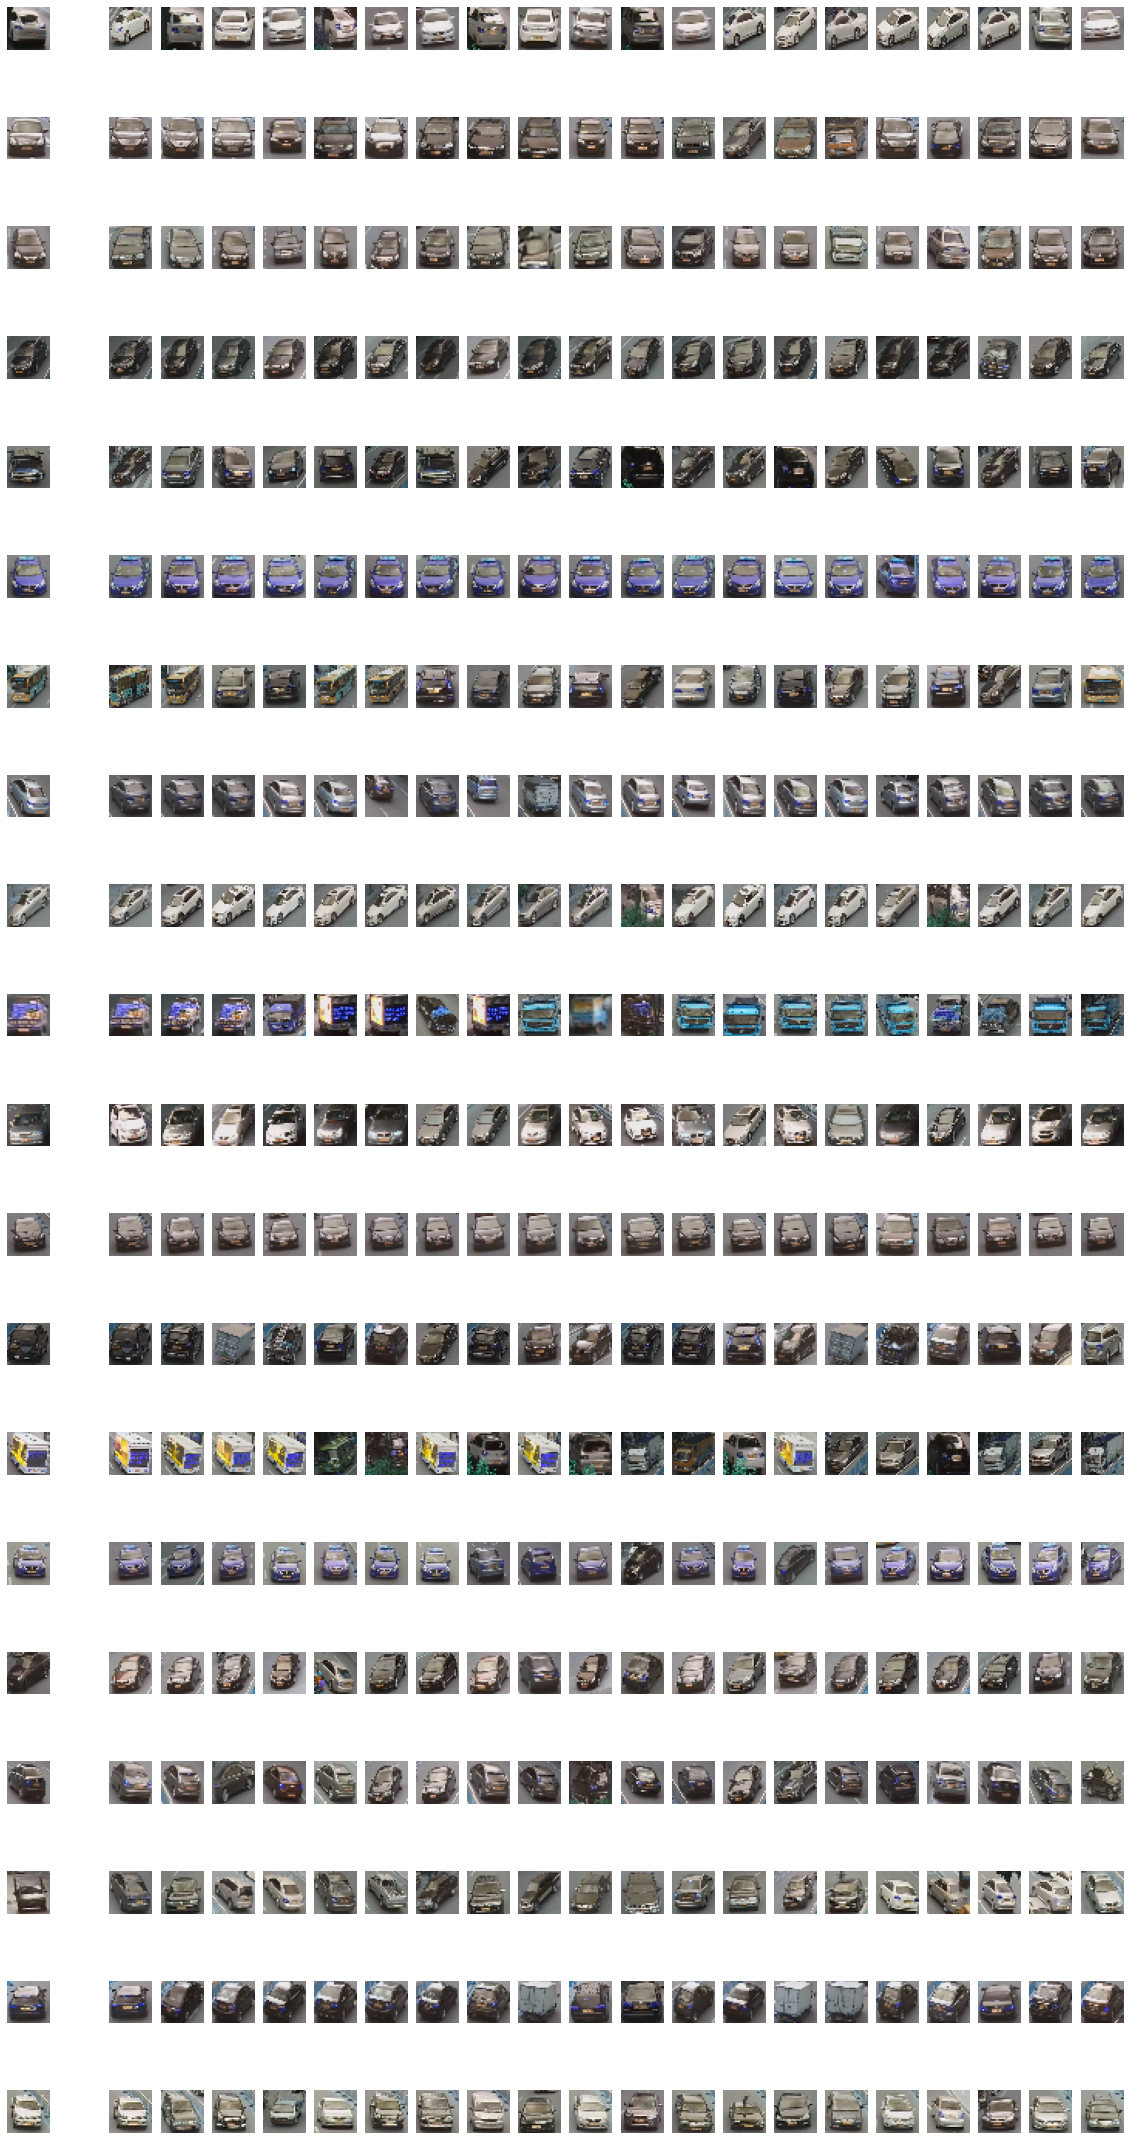

In [24]:
print('**Query Image**       *************************** Top %d Similar Images  ***************************' % K)
show_top_k_images(indx_list,test_image_indexes, train_images, test_images)

In [25]:
IMG_SIZE = 32 # Specify height and width of image to match the input format of the
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observationsmodel
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    #for element in dataset: 
     #     print(element) 
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_img, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset


In [26]:
test_ds = create_dataset(test_dataset[0], test_dataset[1])

In [27]:
# Save test embeddings for visualization in projector
np.savetxt("vecs_imtf.tsv", normalized_search_vecs , delimiter='\t')



In [36]:
import io

In [33]:
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow.compat.v2'

In [37]:
out_m = io.open('meta_imtf.tsv', 'w', encoding='utf-8')
for  labels in test_label:
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

 #https://projector.tensorflow.org/

TypeError: 'numpy.int32' object is not iterable

In [31]:
for img, labels in tfds.as_numpy(test_ds):
    print(img,labels)

NameError: name 'tfds' is not defined

In [38]:
for  labels in test_label:
    [print(x) for x in labels]

TypeError: 'numpy.int32' object is not iterable

In [34]:
test_label

array([273, 500, 594, ..., 239, 565,  38])

                           ---------------------- *** --------------------